In [63]:
"""
Import the packages needed to simulation of detections and modelling orbital distributions.
"""
import ossssim
from ossssim.models import Parametric, Resonant, Implanted
from ossssim import OSSSSim, DetectFile, ModelFile, ModelOutputFile 
from astropy import units
import numpy
import os


In [65]:
# setup some paths to characterization files and where to store your model outputs.
CHARACTERIZATION_DIR="/arc/projects/OSSOS/OSSOSv11/OSSOSv11/ObsSummary/"
MODEL_OUTPUT_DIR=os.getenv('HOME')

In [2]:
# An Example of creating a model for the Twotino (2:1) population using default settings for resonant arguments

twotinos = Resonant(j=2, k=1, seed=123456789, comp='plutino_implanted', size=100, model_band='r')



In [3]:
# We can set various parameters for a orbit model 
print(twotinos.res_amp_high, twotinos.res_amp_low, twotinos.res_amp_mid)

10.0 deg 0.0 deg 5.0 deg


In [4]:
## These values are used as inputs into the 'triangle' distribution that is available in the ossssim.distribution package
help(ossssim.distributions.Distributions.triangle)

Help on function triangle in module ossssim.distributions:

triangle(self, minimum, mid, maximum)
    Generate an array corresponding to a probability density that rises linearly from zero at a
    given minimum bound to a maximum probability at a given mid value, before dropping linearly back to zero at a
    given maximum bound. (i.e. for values less than the mid value, (x-minimum)/(mid-minimum), and for values
    greater than the mid value, (maximum-x)/(maximum-mid).)
    
    Args:
        minimum (float): minimum value of the distribution where probability starts at zero before rising linearly
        towards the mid value.
        mid (float): value of maximum probability between the values of minimum and maximum.
        maximum (float): maximum value of the distribution where probability ends at zero, dropping linearly
        from the mid value.
    Returns:
        numpy.array: resulting random samples.



In [5]:
# One can set those values of the parameters, for example.
twotinos.res_amp_high = 120*units.deg
twotinos.res_amp_low = 60*units.deg
twotinos.res_amp_mid = 90*units.deg

In [22]:
# We can also create new populations by defining a new class of Parametric or other availalbe model type.  
# A Parametric based orbit model gets a 'cold-classical' H-distribution by default while an Implanted based model gets a 
# H-distribution that is more consistent with the hot-classicals

# NOTE The distributions of orbital elemetns are set by defining the functions with names that match the pattern:
# {element}_distribution  (e.g. a_distribution, e_distribution, M_distribution where the value of element is one of
# [a, e, inc, node, peri, M, H, peri, phi]

# NOTE: When defining a distribution we call the distributions attached to the model (e.g. self.distributions.FUNCTION_NAME )
# this is to ensure that all our distributions are seeded with a common random number and we can thuse re-produce a model if 
# we know the seed value.

class Ring(Parametric):
    """
    Class used to create and store the objects generated and passed by the GiMeObj module into the main Driver.py
    module that executes the survey simulator code.
    """
    def __init__(self, ring_centre=45*units.au, ring_width=2*units.au, model_band='r', **kwargs):
        """Build a ring distribution of given with at a given distance.  Ring is edge-on and circular.

        Args:
            ring_center (units.Quantity): The location of the ring, given as unit quantity
            ring_width (units.Quantity): Width of the ring.
        """
        super().__init__(**kwargs)
        self.ring_center = ring_centre
        self.ring_width = ring_width


    @property
    def a_distribution(self):
        """
        Semi-major axis distribution for a narrow ring
        """
        return self.distributions.normal(self.ring_center.to('au').value,
                                    self.ring_width.to('au').value) * units.au


    @property
    def e_distribution(self):
        """
        Eccentricity axis distribution for a narrow ring
        """
        # set the maxium value of 'q' to be 'a', (i.e. circular orbit)
        q = self.distributions.uniform(numpy.where(38<self.a.to('au').value, 38, self.a.to('au').value), self.a.to('au').value)*units.au
        e = ( 1 - q/self.a)
        return e

    @property
    def inc_distribution(self):
        """
        Inclination distribution for a narrow ring
        """
        return self.distributions.uniform(0.0, 4.0) * units.rad

In [66]:
# to determine if an object was detectable we use an OSSSSim object, initializing it with the name of directory holding the 
# survey characterization of interest.
ssim = OSSSSim(characterization_directory=os.path.join(CHARACTERIZATION_DIR,'CFEPS'))

In [50]:
# let's create a model that is 50% twotinos and 50% 'Ring'
from numpy import random
n_detections = n_iterations = n_tracked = 0

def delete_if_file_exists(filename):
    import os
    if os.access(filename, os.F_OK):
        os.remove(filename)

model_filename = os.path.join(MODEL_OUTPUT_DIR,'example_model.txt')
detect_filename = os.path.join(MODEL_OUTPUT_DIR, 'example_detect.txt')

# Create some objects to store our model and our detections.
# First we delete any existing files with these names as all writes are appends.
for filename in [model_filename, detect_filename]:
    delete_if_file_exists(filename)
    
model_save_file=ModelOutputFile(filename=model_filename)
detect_save_file=DetectFile(filename=detect_filename)

# Establish the two model we will select between
ring_model = Ring(ring_centre=45*units.au, ring_width=2.5*units.au, component='cold_classical', model_band='r', size=100)
twotinos = Resonant(j=2, k=1, seed=123456789, component='twotino_implanted', model_band='r', size=100)

total_iterations = 1000

while n_iterations < total_iterations:
    n_iterations += 1
    # the value 'size' indicates how many model objects to create per batch.  A value of '100' is pretty efficieny for our needs.
    model = random.rand() < 0.75 and twotinos or ring_model
    row = next(model)
    model_save_file.write_row(row)
    result = ssim.simulate(row, epoch=model.epoch, colors=model.colors, seed=model.seed, model_band=model.model_band)
    if result['flag'] > 0:
        n_detections += 1
    detect_save_file.write_row(result)

In [54]:
# The model_save_file and detect_dave_file variables still hold the data:
print(model_save_file.table['comp'][0:5])

       comp      
-----------------
twotino_implanted
twotino_implanted
twotino_implanted
twotino_implanted
twotino_implanted


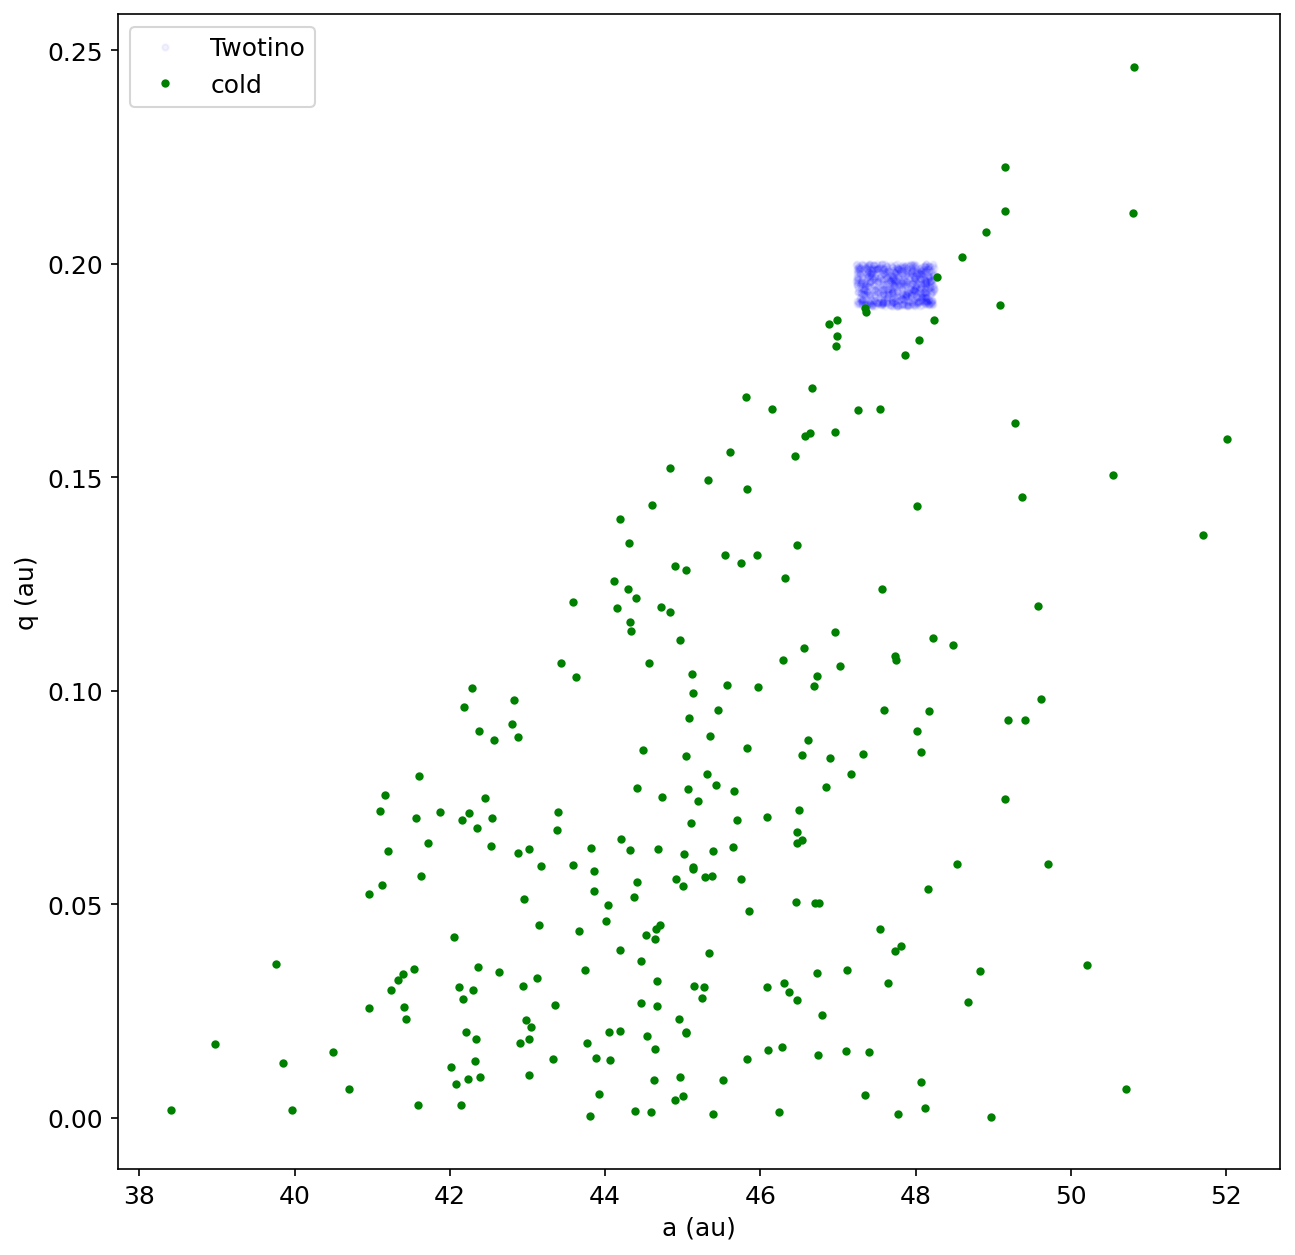

In [61]:
# some cummulative histograms
import matplotlib as mpl
from matplotlib import pyplot
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []
resonant = model_save_file.table['comp'] == 'twotino_implanted'
# plot the plutinos
pyplot.plot(model_save_file.table['a'][resonant], model_save_file.table['e'][resonant], '.b', alpha=0.05, label='Twotino')
# plot the things that aren't plutinos.
pyplot.plot(model_save_file.table['a'][~resonant], model_save_file.table['e'][~resonant], '.g', label='cold')
pyplot.ylabel('q (au)')
pyplot.xlabel('a (au)')
pyplot.legend()

/opt/SSim/python/ossssim/plotter.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax1.set_xticklabels(x_tick_labels, color='b', alpha=0.6)


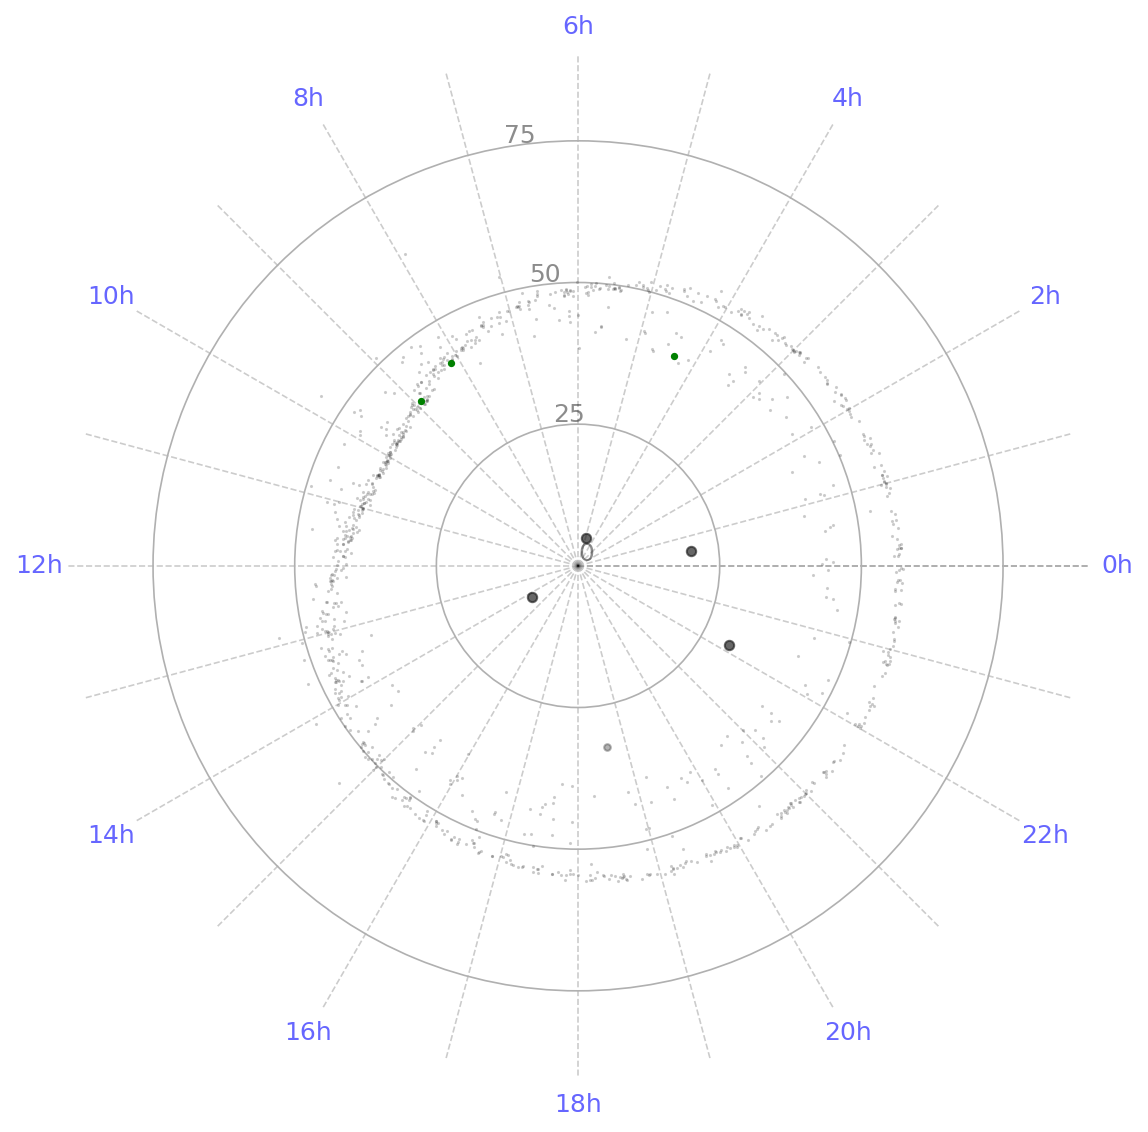

In [59]:
import matplotlib as mpl
from ossssim import plotter
# This installation has no fonts, if working on a local device you might set your font here.
mpl.rcParams['font.family'] = []
mpl.rcParams['font.serif'] = []

plot = plotter.RosePlot(epoch=model_save_file.epoch)
plot.add_model(model_save_file, ms=1, mc='k', alpha=0.2)
plot.add_model(detect_save_file, ms=5, mc='g')
plot.add_planets()
plot.show()
